In [1]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install lime

     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=4d652031feedb905efa12632654b310bb0ba4a836c4b7e713b9a0218cafc5916
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
import os
os.chdir("/content/gdrive/MyDrive/explanations-for-computer-vision/")

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from lime.lime_image import LimeImageExplainer
from src.faster_rcnn import fasterrcnn_resnet18_fpn

from src.utils import jaccard

device = 'cpu'

# our dataset has two classes only - background and person
num_classes = 2

In [4]:
# load an instance segmentation model pre-trained pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
model = fasterrcnn_resnet18_fpn(pretrained_backbone=True, num_classes=num_classes)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load model checkpoint
path = os.path.join(os.getcwd(), "./checkpoints/faster_rcnn_resnet1830_epochs.ckpt")
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device) 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

In [5]:
import sys
sys.path.append("./detection")
from pennfudan_dataset import PennFudanDataset, get_transform

# use our dataset and defined transformations
dataset = PennFudanDataset('./PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('./PennFudanPed', get_transform(train=False))
# changing to array


# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [6]:
#creating test image

image_test = dataset_test[0][0].permute(1,2,0).detach().numpy()
image_test = image_test.astype('double')

In [7]:
from src.sodexplainer import SODExplainer

explainer_sodex = SODExplainer(model=model, num_samples=1000)
explanation = explainer_sodex.get_explanation(image_test,dataset_test[0])

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[0.6647]])
tensor([[0.6757]])
tensor([[0.6225]])
tensor([[0.6831]])
tensor([[0.6157]])
tensor([[0.6215]])
tensor([[0.6236],
        [0.4538]])
tensor([[0.6639]])
tensor([[0.6312]])
tensor([[0.7177]])
tensor([[0.6943]])
tensor([[0.6995]])
tensor([[0.6482]])
tensor([[0.6995]])
tensor([[0.6401]])
tensor([[0.7229]])
tensor([[0.7410]])
tensor([[0.7183]])
tensor([[0.6372]])
tensor([[0.6746]])
tensor([[0.7313]])
tensor([[0.6530]])
tensor([[0.5619]])
tensor([[0.6717]])
tensor([[0.7248]])
tensor([[0.7526]])
tensor([[0.6734]])
tensor([[0.5603]])
tensor([[0.6716]])
tensor([[0.6716]])
tensor([[0.6455],
        [0.4234]])
tensor([[0.6411]])
tensor([[0.6821]])
tensor([[0.6146]])
tensor([[0.7508]])
tensor([[0.6638]])
tensor([[0.6751]])
tensor([[0.6856]])
tensor([[0.6004]])
tensor([[0.6768]])
tensor([[0.6509]])
tensor([[0.6787]])
tensor([[0.7657],
        [0.4343]])
tensor([[0.6787],
        [0.4247]])
tensor([[0.6814]])
tensor([[0.5458]])
tensor([[0.6928]])
tensor([[0.6435]])
tensor([[0.6605]

(-0.5, 454.5, 413.5, -0.5)

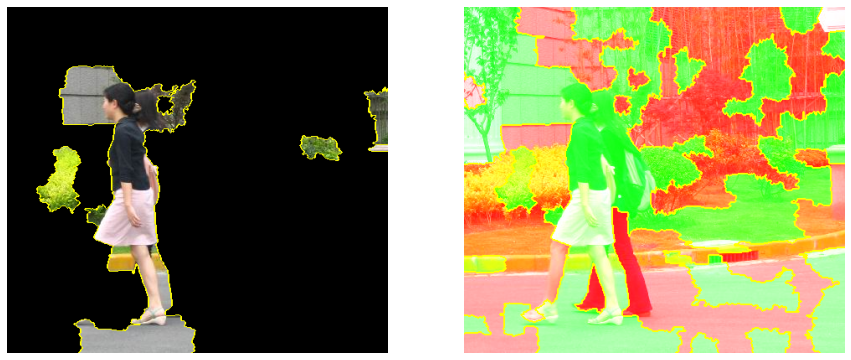

In [19]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=200, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

In [9]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])



In [10]:
from PIL import Image, ImageDraw

result = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
image = ImageDraw.Draw(result)  

for bbox in prediction[0]["boxes"]:
  image.rectangle(bbox.cpu().numpy().tolist(), outline ="red")



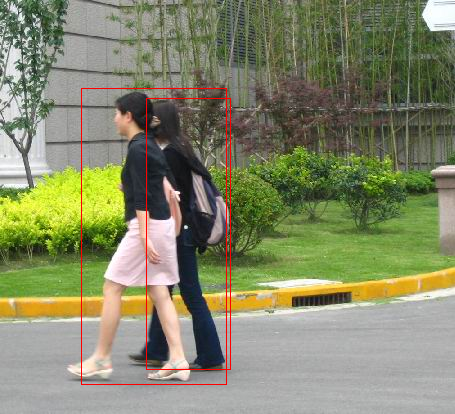

In [11]:
result